In [1]:
import json
import os
import re
from typing import List, Tuple

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import tqdm

In [2]:
wikidata_user_agent = "ask_type_query/0.1 (federico.belotti@unimib.it))"

### Alligator analysis

In [3]:
gt_path = "/home/belerico/Desktop/unimib/business cases/gh/alligator_gh/gt/cea_gt.csv"
tables_path = "/home/belerico/Desktop/unimib/business cases/gh/alligator_gh/tables/"
results_dir = "/home/belerico/Desktop/unimib/business cases/gh/results_alligator/"

In [4]:
dataset_name = "gh-end-to-end-nil"

In [5]:
gt = pd.read_csv(gt_path, header=None)
gt.columns = ["table_name", "row", "col", "qid"]
tables_names = gt["table_name"].unique().tolist()
url_regex = re.compile(r"http(s)?\:\/\/www\.wikidata\.org\/(wiki|entity)\/")
gt["qid"] = gt["qid"].map(lambda x: url_regex.sub("", x))
gt_mapping = {f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid} for row in gt.itertuples()}

In [6]:
gt

,table_name,row,col,qid
0,gh_annotated_alligator,1,0,NIL
1,gh_annotated_alligator,2,0,NIL
2,gh_annotated_alligator,3,0,NIL
3,gh_annotated_alligator,4,0,NIL
4,gh_annotated_alligator,5,0,NIL
...,...,...,...,...
304,gh_annotated_alligator,305,0,Q924265
305,gh_annotated_alligator,306,0,Q9295735
306,gh_annotated_alligator,307,0,Q95
307,gh_annotated_alligator,308,0,Q97040890


In [7]:
read_from_server = False

In [8]:
if read_from_server:
    tp = 0
    annotations = []
    all_gt = len(gt)
    all_predicted = 0
    current_table = None
    current_table_name = None
    alligator_annotations = None
    for table_name in tqdm.tqdm(tables_names):
        if table_name != current_table_name:
            current_table_name = table_name
            response = requests.get(
                "http://localhost:5042/dataset/{}/table/{}?token=alligator_demo_2023".format(
                    dataset_name, current_table_name
                ),
                headers={
                    "accept": "application/json",
                    "Content-Type": "application/json",
                },
            )
            if response:
                alligator_annotations = response.json()
                annotations.append(alligator_annotations)
                alligator_annotations = alligator_annotations["semanticAnnotations"]["cea"]
            else:
                alligator_annotations = []
            for annotation in alligator_annotations:
                key = "{}-{}-{}".format(current_table_name, annotation["idRow"], annotation["idColumn"])
                # if key in gt_mapping_nil:
                #     continue
                if key not in gt_mapping:
                    continue
                predicted_qid = ""
                if len(annotation["entity"]) > 0:
                    all_predicted += 1
                    predicted_qid = annotation["entity"][0]["id"]
                if predicted_qid != "" and predicted_qid in gt_mapping[key]["target"]:
                    tp += 1

    # Print results
    precision = tp / all_predicted
    recall = tp / all_gt
    f1 = 2 * (precision * recall) / (precision + recall)
    print(all_gt, all_predicted)
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1: {:.4f}".format(f1))

    # Save alligator results
    os.makedirs(os.path.join(results_dir, dataset_name), exist_ok=True)
    with open(os.path.join(results_dir, dataset_name, "alligator_annotations.json"), "w+") as f:
        json.dump(annotations, f)
else:
    with open(os.path.join(results_dir, dataset_name, "alligator_annotations.json"), "r") as f:
        annotations = json.load(open(os.path.join(results_dir, dataset_name, "alligator_annotations.json")))

In [9]:
gt_only_annotations = []

for i, table_annotations in enumerate(annotations):
    table = pd.read_csv(os.path.join(tables_path, "{}.csv".format(tables_names[i])))
    table = table.drop(columns=["idd", "id"])
    for annotation in table_annotations["semanticAnnotations"]["cea"]:
        key = "{}-{}-{}".format(tables_names[i], annotation["idRow"], annotation["idColumn"])
        if key not in gt_mapping:
            continue
        gt_only_annotations.append(annotation)
        gt_only_annotations[-1]["table_name"] = tables_names[i]
        gt_only_annotations[-1]["target"] = gt_mapping[key]["target"]
        gt_only_annotations[-1]["row"] = annotation["idRow"]
        gt_only_annotations[-1]["col"] = annotation["idColumn"]
        gt_only_annotations[-1]["mention"] = table.iloc[annotation["idRow"] - 1, annotation["idColumn"]]

In [10]:
len(gt_only_annotations)

309

In [43]:
gt_only_annotations_df = []
for annotation in gt_only_annotations:
    gt_only_annotations_df.append(
        {
            "table_name": annotation["table_name"],
            "row": annotation["idRow"],
            "col": annotation["idColumn"],
            "candidates": len(annotation["entity"]),
            "score": annotation["entity"][0]["score"] if len(annotation["entity"]) > 0 else 0,
            "target": annotation["target"],
            "prediction": annotation["entity"][0]["id"] if len(annotation["entity"]) > 0 else "",
            "target_in_candidates": annotation["target"] in [c["id"] for c in annotation["entity"]],
            "mention": annotation["mention"],
        }
    )

In [44]:
gt_only_annotations_df = pd.DataFrame(gt_only_annotations_df)

In [45]:
gt_only_annotations_df.head()

,table_name,row,col,candidates,score,target,prediction,target_in_candidates,mention
0,gh_annotated_alligator,51,0,91,0.057,NIL,Q59601635,False,Finance House PJSC
1,gh_annotated_alligator,52,0,100,0.112,NIL,Q19961295,False,Freeman Lab
2,gh_annotated_alligator,53,0,0,0.000,NIL,,False,@fullstacklabs
3,gh_annotated_alligator,54,0,4,0.941,NIL,Q99945341,False,gama-soft
4,gh_annotated_alligator,55,0,96,0.031,NIL,Q9252469,False,Halm Elektronik


In [46]:
gt_only_annotations_df["alligator_match"] = (
    gt_only_annotations_df["prediction"] == gt_only_annotations_df["target"]
).astype(int)

In [47]:
gt_only_annotations_df["nil_label"] = np.where(
    gt_only_annotations_df["target"].to_numpy() == "NIL", "NIL", "Not NIL"
)

In [48]:
gt_only_annotations_df_sub = gt_only_annotations_df.copy()
gt_only_annotations_df_sub

,table_name,row,col,candidates,score,target,prediction,target_in_candidates,mention,alligator_match,nil_label
0,gh_annotated_alligator,51,0,91,0.057,NIL,Q59601635,False,Finance House PJSC,0,NIL
1,gh_annotated_alligator,52,0,100,0.112,NIL,Q19961295,False,Freeman Lab,0,NIL
2,gh_annotated_alligator,53,0,0,0.000,NIL,,False,@fullstacklabs,0,NIL
3,gh_annotated_alligator,54,0,4,0.941,NIL,Q99945341,False,gama-soft,0,NIL
4,gh_annotated_alligator,55,0,96,0.031,NIL,Q9252469,False,Halm Elektronik,0,NIL
...,...,...,...,...,...,...,...,...,...,...,...
304,gh_annotated_alligator,305,0,86,0.809,Q924265,Q924265,True,Aarhus University,1,Not NIL
305,gh_annotated_alligator,306,0,91,0.024,Q9295735,Q4652575,True,AMC Networks SE,0,Not NIL
306,gh_annotated_alligator,307,0,74,0.024,Q95,Q63707237,False,Student at Google,0,Not NIL
307,gh_annotated_alligator,308,0,2,0.001,Q97040890,Q97040890,True,Infervision,1,Not NIL


In [49]:
gt_only_annotations_df_sub[["alligator_match"]].mean(axis=0)

alligator_match    0.229773
dtype: float64

In [50]:
gt_only_annotations_df_sub[gt_only_annotations_df_sub["target"] != "NIL"][["alligator_match"]].mean(axis=0)

alligator_match    0.398876
dtype: float64

In [51]:
gt_only_annotations_df_sub.groupby("nil_label")["nil_label"].value_counts()

nil_label
NIL        131
Not NIL    178
Name: count, dtype: int64

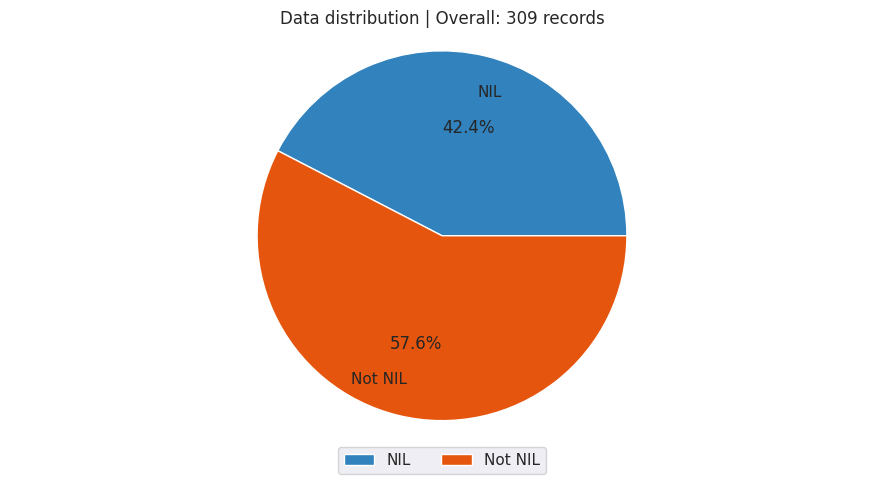

In [52]:
sns.set_context("paper")
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(9, 5))
size = 0.3
nil = gt_only_annotations_df_sub.groupby("nil_label")["nil_label"].value_counts()
vals = nil.to_numpy()
cmap = plt.get_cmap("tab20c")
inner_colors = cmap(np.arange(3) * 4)
ax.pie(
    vals.flatten(),
    colors=inner_colors,
    labels=["NIL", "Not NIL"],
    autopct="%1.1f%%",
    labeldistance=0.8,
    wedgeprops=dict(edgecolor="w"),
)

plt.legend()
sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5, -0.0), ncol=3)
plt.axis("equal")
plt.title(f"Data distribution | Overall: {len(gt_only_annotations_df_sub)} records")
plt.tight_layout()
plt.show()

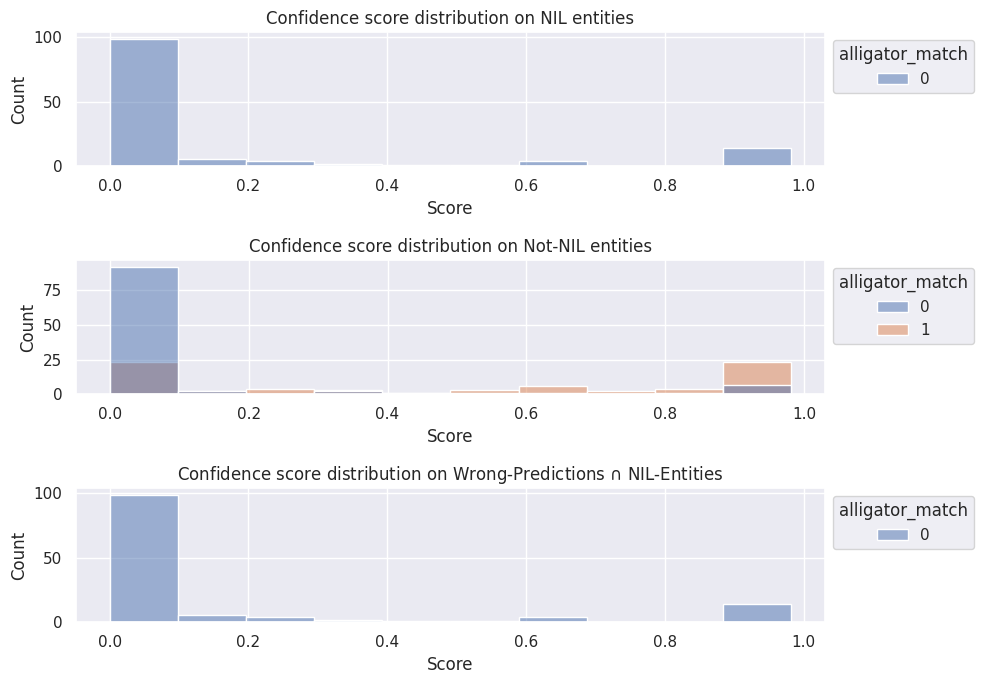

In [53]:
sns.set_context("paper")
sns.set_theme(style="darkgrid")
bins = 10
colors = sns.color_palette("flare", n_colors=10, as_cmap=False)
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharey=False)
sns.histplot(
    gt_only_annotations_df_sub[gt_only_annotations_df_sub["target"] == "NIL"],
    x="score",
    ax=axes[0],
    legend=True,
    bins=bins,
    hue="alligator_match",
)
sns.move_legend(axes[0], "upper left", bbox_to_anchor=(1, 1))
axes[0].xaxis.set_label_text("Score")
axes[0].yaxis.set_label_text("Count")
axes[0].set_title("Confidence score distribution on NIL entities")
sns.histplot(
    gt_only_annotations_df_sub[gt_only_annotations_df_sub["target"] != "NIL"],
    x="score",
    ax=axes[1],
    legend=True,
    hue="alligator_match",
    bins=bins,
)
sns.move_legend(axes[1], "upper left", bbox_to_anchor=(1, 1))
axes[1].xaxis.set_label_text("Score")
axes[1].yaxis.set_label_text("Count")
axes[1].set_title("Confidence score distribution on Not-NIL entities")
sns.histplot(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["alligator_match"] == 0) & (gt_only_annotations_df_sub["target"] == "NIL")
    ],
    x="score",
    ax=axes[2],
    legend=True,
    hue="alligator_match",
    bins=bins,
)
sns.move_legend(axes[2], "upper left", bbox_to_anchor=(1, 1))
axes[2].xaxis.set_label_text("Score")
axes[2].yaxis.set_label_text("Count")
axes[2].set_title("Confidence score distribution on Wrong-Predictions $\cap$ NIL-Entities")
plt.tight_layout()
plt.show()

In [54]:
# Prediction with NIL threshold = 0.2
gt_only_annotations_df_sub["nil_prediction@0.2"] = np.where(
    gt_only_annotations_df_sub["score"] > 0.2, gt_only_annotations_df_sub["prediction"], "NIL"
)
gt_only_annotations_df_sub["nil_match@0.2"] = (
    gt_only_annotations_df_sub["nil_prediction@0.2"] == gt_only_annotations_df_sub["target"]
).astype(int)

In [55]:
alligator_tp = 0
alligator_predicted = 0
alligator_annotations = 0
for row in gt_only_annotations_df_sub.itertuples(index=False):
    alligator_annotations += 1
    if row.candidates == 0:
        continue
    alligator_predicted += 1
    alligator_tp += row.alligator_match
alligator_recall = alligator_tp / alligator_annotations
alligator_precision = alligator_tp / alligator_predicted
alligator_f1 = 2 * (alligator_precision * alligator_recall) / (alligator_precision + alligator_recall)
print("Precision: {:.4f}".format(alligator_precision))
print("Recall: {:.4f}".format(alligator_recall))
print("F1: {:.4f}".format(alligator_f1))

Precision: 0.2545
Recall: 0.2298
F1: 0.2415


In [56]:
nil_tp = 0
nil_predicted = 0
nil_annotations = 0
for _, row in gt_only_annotations_df_sub.iterrows():
    nil_annotations += 1
    if row["candidates"] == 0:
        continue
    nil_predicted += 1
    nil_tp += row["nil_match@0.2"]
nil_recall = nil_tp / nil_annotations
nil_precision = nil_tp / nil_predicted
nil_f1 = 2 * (nil_precision * nil_recall) / (nil_precision + nil_recall)
print("Precision: {:.4f}".format(nil_precision))
print("Recall: {:.4f}".format(nil_recall))
print("F1: {:.4f}".format(nil_f1))

Precision: 0.4803
Recall: 0.4337
F1: 0.4558


In [57]:
thresholds = np.linspace(0, 1, 25)
precisions = []
recalls = []
f1s = []

for threshold in thresholds:
    nil_predictions = np.where(
        gt_only_annotations_df_sub["score"] > threshold, gt_only_annotations_df_sub["prediction"], "NIL"
    )
    nil_matches = (nil_predictions == gt_only_annotations_df_sub["target"]).astype(int)
    tp = 0
    predicted = 0
    annotations = 0
    for i, (_, row) in enumerate(gt_only_annotations_df_sub.iterrows()):
        annotations += 1
        if row["candidates"] == 0:
            continue
        predicted += 1
        tp += nil_matches.iloc[i]
    recall = tp / annotations
    precision = tp / predicted
    f1 = 2 * (precision * recall) / (precision + recall)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

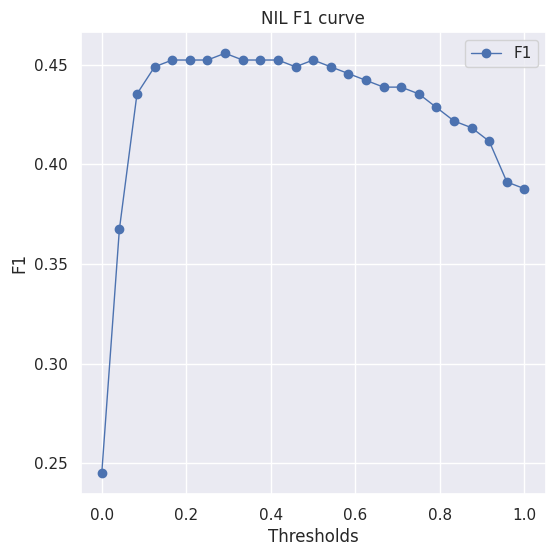

In [58]:
# Plot precision-recall curve against thresholds
sns.set_context("paper")
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.plot(thresholds, recalls, marker="o", label="Recall", markersize=3)
# ax.plot(thresholds, precisions, marker="x", color="red", alpha=0.5, label="Precision")
ax.plot(thresholds, f1s, marker="o", label="F1", linewidth=1)
plt.legend()
plt.xlabel("Thresholds")
plt.ylabel("F1")
plt.title("NIL F1 curve")
plt.show()

In [27]:
gt_only_annotations_df_sub[(gt_only_annotations_df_sub["score"] >= 0.8) & (gt_only_annotations_df_sub["target"] == "NIL")]

,table_name,row,col,candidates,score,target,prediction,target_in_candidates,mention,alligator_match,nil_label,nil_prediction@0.2,nil_match@0.2
3,gh_annotated_alligator,54,0,4,0.941,NIL,Q99945341,False,gama-soft,0,NIL,Q99945341,0
6,gh_annotated_alligator,57,0,94,0.970,NIL,Q12806166,False,Headstorm,0,NIL,Q12806166,0
15,gh_annotated_alligator,66,0,857,0.978,NIL,Q123461409,False,Betsol,0,NIL,Q123461409,0
38,gh_annotated_alligator,14,0,710,0.980,NIL,Q5427569,False,FarMart,0,NIL,Q5427569,0
52,gh_annotated_alligator,78,0,898,0.958,NIL,Q107246010,False,@OSCOWL,0,NIL,Q107246010,0
55,gh_annotated_alligator,81,0,370,0.975,NIL,Q76649708,False,Recruitics,0,NIL,Q76649708,0
62,gh_annotated_alligator,88,0,3,0.914,NIL,Q11855343,False,ZimmCorp,0,NIL,Q11855343,0
80,gh_annotated_alligator,31,0,873,0.952,NIL,Q21508459,False,"VP, SpringML",0,NIL,Q21508459,0
92,gh_annotated_alligator,43,0,34,0.971,NIL,Q12963240,False,Datakalab,0,NIL,Q12963240,0
98,gh_annotated_alligator,49,0,99,0.982,NIL,Q48563001,False,Executive Order builds complex systems for aut...,0,NIL,Q48563001,0


In [28]:
read_labels_and_descs_from_file = True
if read_labels_and_descs_from_file:
    with open("labels_and_descs.json", "r") as f:
        labels_and_descs = json.load(f)
else:
    labels_and_descs = {}

In [29]:
# Retrieve from wikidata infos about the NIL predictions
labels_and_descs_df = []
for row in tqdm.tqdm(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["score"] >= 0.8) & (gt_only_annotations_df_sub["target"] == "NIL")
    ].itertuples(index=True)
):
    if row.prediction in labels_and_descs:
        labels_and_descs_df.append(
            {
                "index": row.Index,
                "prediction": row.prediction,
                "mention": row.mention,
                "wikidata_label": labels_and_descs[row.prediction]["label"],
                "wikidata_description": labels_and_descs[row.prediction]["desc"],
            }
        )
        continue
    params = {
        "action": "wbgetentities",
        "format": "json",
        "languages": "en",
        "ids": row.prediction,
        "props": "labels|descriptions",
    }
    wikidata_response = requests.get(
        "https://www.wikidata.org/w/api.php", params=params, headers={"User-Agent": wikidata_user_agent}
    )
    wikidata_response = wikidata_response.json()
    if wikidata_response is not None:
        labels_and_descs[row.prediction] = {
            "label": wikidata_response["entities"][row.prediction].get("labels", {}).get("en", {}).get("value", ""),
            "desc": wikidata_response["entities"][row.prediction]
            .get("descriptions", {})
            .get("en", {})
            .get("value", ""),
        }
        labels_and_descs_df.append(
            {
                "index": row.Index,
                "prediction": row.prediction,
                "mention": row.mention,
                "wikidata_label": wikidata_response["entities"][row.prediction]
                .get("labels", {})
                .get("en", {})
                .get("value", ""),
                "wikidata_description": wikidata_response["entities"][row.prediction]
                .get("descriptions", {})
                .get("en", {})
                .get("value", ""),
            }
        )
    else:
        labels_and_descs_df.append(
            {
                "index": row.Index,
                "prediction": row.prediction,
                "mention": row.mention,
                "wikidata_label": "",
                "wikidata_description": "",
            }
        )
        labels_and_descs_df.append(
            {
                "index": row.Index,
                "prediction": row.prediction,
                "mention": row.mention,
                "wikidata_label": "",
                "wikidata_description": "",
            }
        )
labels_and_descs_df = pd.DataFrame(labels_and_descs_df)
labels_and_descs_df = labels_and_descs_df.set_index("index", drop=True)
with open("labels_and_descs.json", "w+") as f:
    json.dump(labels_and_descs, f)

14it [00:00, 111635.47it/s]


In [30]:
labels_and_descs_df.reset_index(drop=True)

,prediction,mention,wikidata_label,wikidata_description
0,Q99945341,gama-soft,Kawa-Soft,"association whose objective is the ""Promotion ..."
1,Q12806166,Headstorm,headstock,part of lathe
2,Q123461409,Betsol,Bridle,bridle in the collection of the Swedish Histor...
3,Q5427569,FarMart,FabMart,
4,Q107246010,@OSCOWL,Roscol,family name
5,Q76649708,Recruitics,recruiting,recruitment status in clinical trials
6,Q11855343,ZimmCorp,Cimcorp,
7,Q21508459,"VP, SpringML",Sprengel,family name
8,Q12963240,Datakalab,Datkilab,Speech technique that involves reversing the v...
9,Q48563001,Executive Order builds complex systems for aut...,"Disease Management, Case Management, Care Mana...",scientific article published in May 2016


In [31]:
(labels_and_descs_df["mention"].str.lower() == labels_and_descs_df["wikidata_label"].str.lower()).sum().item(), len(
    labels_and_descs_df
), ((labels_and_descs_df["mention"].str.lower() == labels_and_descs_df["wikidata_label"].str.lower()).sum() / len(
    labels_and_descs_df
)).item()

(0, 14, 0.0)

In [32]:
read_wikidata_annotation_from_file = True
if read_wikidata_annotation_from_file:
    with open(os.path.join("wikidata_annotated_mentions.json"), "r") as f:
        annotated_mentions = json.load(f)
else:
    annotated_mentions = {}

In [33]:
# Annotate with wikidata
wikidata_predictions = []
for row in tqdm.tqdm(gt_only_annotations_df_sub.itertuples(index=True), total=len(gt_only_annotations_df_sub)):
    mention = row.mention
    if mention in annotated_mentions:
        wikidata_predictions.append(
            {"index": row.Index, "wikidata_prediction": annotated_mentions[mention]["wikidata_prediction"]}
        )
        continue
    params = {
        "action": "wbsearchentities",
        "format": "json",
        "language": "en",
        "search": mention,
        "limit": 5,
    }
    headers = {"User-Agent": wikidata_user_agent}
    wikidata_response = requests.get("https://www.wikidata.org/w/api.php", params=params, headers=headers)
    wikidata_response = wikidata_response.json()
    if wikidata_response is not None:
        annotated_mentions[mention] = {
            "index": row.Index,
            "wikidata_prediction": (
                wikidata_response["search"][0]["id"] if len(wikidata_response["search"]) > 0 else ""
            ),
        }
        wikidata_predictions.append(annotated_mentions[mention])
json.dump(annotated_mentions, open("wikidata_annotated_mentions.json", "w+"))

100%|██████████| 309/309 [00:00<00:00, 194571.38it/s]


In [34]:
wikidata_predictions_df = pd.DataFrame(wikidata_predictions)
wikidata_predictions_df = wikidata_predictions_df.set_index("index", drop=True)
wikidata_predictions_df

,wikidata_prediction
index,
0,
1,
2,
3,
4,
...,...
304,Q924265
305,
306,


In [35]:
pd.merge(gt_only_annotations_df_sub, wikidata_predictions_df, left_index=True, right_index=True, sort=False)

,table_name,row,col,candidates,score,target,prediction,target_in_candidates,mention,alligator_match,nil_label,nil_prediction@0.2,nil_match@0.2,wikidata_prediction
0,gh_annotated_alligator,51,0,91,0.057,NIL,Q59601635,False,Finance House PJSC,0,NIL,NIL,1,
1,gh_annotated_alligator,52,0,100,0.112,NIL,Q19961295,False,Freeman Lab,0,NIL,NIL,1,
2,gh_annotated_alligator,53,0,0,0.000,NIL,,False,@fullstacklabs,0,NIL,NIL,1,
3,gh_annotated_alligator,54,0,4,0.941,NIL,Q99945341,False,gama-soft,0,NIL,Q99945341,0,
4,gh_annotated_alligator,55,0,96,0.031,NIL,Q9252469,False,Halm Elektronik,0,NIL,NIL,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,gh_annotated_alligator,305,0,86,0.809,Q924265,Q924265,True,Aarhus University,1,Not NIL,Q924265,1,Q924265
305,gh_annotated_alligator,306,0,91,0.024,Q9295735,Q4652575,True,AMC Networks SE,0,Not NIL,NIL,0,
306,gh_annotated_alligator,307,0,74,0.024,Q95,Q63707237,False,Student at Google,0,Not NIL,NIL,0,
307,gh_annotated_alligator,308,0,2,0.001,Q97040890,Q97040890,True,Infervision,1,Not NIL,NIL,0,Q97040890


In [36]:
gt_only_annotations_df_sub = pd.merge(gt_only_annotations_df_sub, wikidata_predictions_df, left_index=True, right_index=True)
gt_only_annotations_df_sub

,table_name,row,col,candidates,score,target,prediction,target_in_candidates,mention,alligator_match,nil_label,nil_prediction@0.2,nil_match@0.2,wikidata_prediction
0,gh_annotated_alligator,51,0,91,0.057,NIL,Q59601635,False,Finance House PJSC,0,NIL,NIL,1,
1,gh_annotated_alligator,52,0,100,0.112,NIL,Q19961295,False,Freeman Lab,0,NIL,NIL,1,
2,gh_annotated_alligator,53,0,0,0.000,NIL,,False,@fullstacklabs,0,NIL,NIL,1,
3,gh_annotated_alligator,54,0,4,0.941,NIL,Q99945341,False,gama-soft,0,NIL,Q99945341,0,
4,gh_annotated_alligator,55,0,96,0.031,NIL,Q9252469,False,Halm Elektronik,0,NIL,NIL,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,gh_annotated_alligator,305,0,86,0.809,Q924265,Q924265,True,Aarhus University,1,Not NIL,Q924265,1,Q924265
305,gh_annotated_alligator,306,0,91,0.024,Q9295735,Q4652575,True,AMC Networks SE,0,Not NIL,NIL,0,
306,gh_annotated_alligator,307,0,74,0.024,Q95,Q63707237,False,Student at Google,0,Not NIL,NIL,0,
307,gh_annotated_alligator,308,0,2,0.001,Q97040890,Q97040890,True,Infervision,1,Not NIL,NIL,0,Q97040890


In [37]:
wikidata_tp = 0
wikidata_predicted = 0
wikidata_annotations = 0
for row in gt_only_annotations_df_sub.itertuples(index=False):
    wikidata_annotations += 1
    if row.wikidata_prediction == "":
        continue
    wikidata_predicted += 1
    wikidata_tp += int(row.target == row.wikidata_prediction)
wikidata_recall = wikidata_tp / wikidata_annotations
wikidata_precision = wikidata_tp / wikidata_predicted
wikidata_f1 = 2 * (wikidata_precision * wikidata_recall) / (wikidata_precision + wikidata_recall)
print("Precision: {:.4f}".format(wikidata_precision))
print("Recall: {:.4f}".format(wikidata_recall))
print("F1: {:.4f}".format(wikidata_f1))

Precision: 0.6847
Recall: 0.2460
F1: 0.3619


In [38]:
gt_only_annotations_df_sub.to_csv(os.path.join(results_dir, dataset_name, f"alligator_results_subset_all.csv"), index=False)

### TableLlama analysis

In [39]:
gt_path = "/home/belerico/Desktop/unimib/business cases/gh/alligator_gh/gt/cea_gt.csv"
results_path = "/home/belerico/Desktop/unimib/business cases/gh/results_tablellama/subsampled_ctx_red_5_gh_end_to_end_prompts_analysis.json"

In [40]:
results = json.load(open(results_path))

In [41]:
gt = pd.read_csv(gt_path, header=None)
gt.columns = ["table_name", "row", "col", "qid"]
tables_names = gt["table_name"].unique().tolist()
url_regex = re.compile(r"http(s)?\:\/\/www\.wikidata\.org\/(wiki|entity)\/")
gt["qid"] = gt["qid"].map(lambda x: url_regex.sub("", x))
gt_mapping = {f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid} for row in gt.itertuples()}

In [42]:
gt

,table_name,row,col,qid
0,gh_annotated_alligator,1,0,NIL
1,gh_annotated_alligator,2,0,NIL
2,gh_annotated_alligator,3,0,NIL
3,gh_annotated_alligator,4,0,NIL
4,gh_annotated_alligator,5,0,NIL
...,...,...,...,...
304,gh_annotated_alligator,305,0,Q924265
305,gh_annotated_alligator,306,0,Q9295735
306,gh_annotated_alligator,307,0,Q95
307,gh_annotated_alligator,308,0,Q97040890


In [43]:
tablellama_df = []
for example in results:
    tablellama_df.append(
        {
            "target": example["qid"],
            "table_name": example["table_id"],
            "row": example["entity"][0][0] + 1,
            "col": example["entity"][0][1],
            "target_in_candidates": example["target_in_candidates"],
            "tablellama_output": example["tablellama_output"],
            "tablellama_match": example["correct"],
            "tablellama_no_space_match": int(
                "".join(example["output"].replace("DESCRIPTION", "DESC").lower().split())
                in "".join(example["tablellama_output"].split())
            ),
            "gt_output": example["output"],
            "mention": example["entity"][1],
            "candidates": example["candidates_count"],
        }
    )

In [44]:
tablellama_df = pd.DataFrame(tablellama_df)
tablellama_df

,target,table_name,row,col,target_in_candidates,tablellama_output,tablellama_match,tablellama_no_space_match,gt_output,mention,candidates
0,NIL,gh_annotated_alligator,1,0,False,<research [desc] systematic study undertaken t...,0,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,Akkodis Research,43
1,NIL,gh_annotated_alligator,2,0,False,<amagi [desc] japanese family name (天城) [type]...,0,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,Amagi Media Labs,36
2,NIL,gh_annotated_alligator,3,0,False,<conference of solidarity support organization...,0,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,CLUMOSS(Clusters of Multi Organizations for Su...,50
3,NIL,gh_annotated_alligator,4,0,False,<christensen [desc] family name [type] patrony...,0,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,Christensen Associates,49
4,NIL,gh_annotated_alligator,5,0,False,<quiller consultants [desc] british lobbying a...,0,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,Core Consultants,51
...,...,...,...,...,...,...,...,...,...,...,...
304,Q924265,gh_annotated_alligator,305,0,True,<aarhus university [desc] public university in...,1,1,<Aarhus University [DESCRIPTION] public univer...,Aarhus University,50
305,Q9295735,gh_annotated_alligator,306,0,True,<amc networks [desc] american entertainment co...,0,0,<AMC Networks International Southern Europe [D...,AMC Networks SE,46
306,Q95,gh_annotated_alligator,307,0,False,<google developer student clubs [desc] develop...,0,0,<Google [DESCRIPTION] American multinational t...,Student at Google,44
307,Q97040890,gh_annotated_alligator,308,0,True,<infervision (china) [desc] company in beijing...,1,1,<InferVision (China) [DESCRIPTION] company in ...,Infervision,2


In [45]:
# tablellama_df = get_subset(tablellama_df, subset)
# tablellama_df

In [46]:
tllama_tp = 0
tllama_predicted = 0
tllama_annotations = 0
for row in tablellama_df.itertuples(index=False):
    tllama_annotations += 1
    if row.candidates == 0:
        continue
    tllama_predicted += 1
    tllama_tp += int(bool(row.tablellama_match) or bool(row.tablellama_no_space_match))
tllama_recall = tllama_tp / tllama_annotations
tllama_precision = tllama_tp / tllama_predicted
tllama_f1 = 2 * (tllama_precision * tllama_recall) / (tllama_precision + tllama_recall)
print("Precision: {:.4f}".format(tllama_precision))
print("Recall: {:.4f}".format(tllama_recall))
print("F1: {:.4f}".format(tllama_f1))

Precision: 0.3560
Recall: 0.3560
F1: 0.3560


### GPT-4o analysis

In [47]:
gt_path = "/home/belerico/Desktop/unimib/business cases/gh/alligator_gh/gt/cea_gt.csv"
results_path = "/home/belerico/Desktop/unimib/business cases/gh/results_gpt4o_2024-02-15-preview/gh_end_to_end_prompts/subsampled_ctx_red_5_gh_end_to_end_prompts_gpt4o.json"

In [48]:
results = json.load(open(results_path))

In [49]:
gt = pd.read_csv(gt_path, header=None)
gt.columns = ["table_name", "row", "col", "qid"]
tables_names = gt["table_name"].unique().tolist()
url_regex = re.compile(r"http(s)?\:\/\/www\.wikidata\.org\/(wiki|entity)\/")
gt["qid"] = gt["qid"].map(lambda x: url_regex.sub("", x))
gt_mapping = {f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid} for row in gt.itertuples()}

In [50]:
gt

,table_name,row,col,qid
0,gh_annotated_alligator,1,0,NIL
1,gh_annotated_alligator,2,0,NIL
2,gh_annotated_alligator,3,0,NIL
3,gh_annotated_alligator,4,0,NIL
4,gh_annotated_alligator,5,0,NIL
...,...,...,...,...
304,gh_annotated_alligator,305,0,Q924265
305,gh_annotated_alligator,306,0,Q9295735
306,gh_annotated_alligator,307,0,Q95
307,gh_annotated_alligator,308,0,Q97040890


In [51]:
cand_pat = re.compile(r"(?<=\<).+?(?=\>)")

In [52]:
cand_lengths = []
for example in results:
    question = example["question"]
    cand_lengths.append(len(cand_pat.findall(question)))

In [53]:
gpt_df = []
for i, example in enumerate(results):
    gpt_df.append(
        {
            "target": example["qid"],
            "table_name": example["table_id"],
            "row": example["entity"][0][0] + 1,
            "col": example["entity"][0][1],
            "target_in_candidates": example["target_in_candidates"],
            "gpt_output": example["gpt_output"],
            "gpt_match": example["gpt_correct"],
            "gpt_no_space_match": int(
                "".join(example["output"].lower().split())
                in "".join(example["gpt_output"].split())
            ),
            "gt_output": example["output"],
            "mention": example["entity"][1],
            "candidates": cand_lengths[i],
        }
    )

In [54]:
gpt_df = pd.DataFrame(gpt_df)
gpt_df

,target,table_name,row,col,target_in_candidates,gpt_output,gpt_match,gpt_no_space_match,gt_output,mention,candidates
0,NIL,gh_annotated_alligator,1,0,False,nil,1,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,Akkodis Research,43
1,NIL,gh_annotated_alligator,2,0,False,nil,1,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,Amagi Media Labs,36
2,NIL,gh_annotated_alligator,3,0,False,nil,1,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,CLUMOSS(Clusters of Multi Organizations for Su...,50
3,NIL,gh_annotated_alligator,4,0,False,nil,1,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,Christensen Associates,49
4,NIL,gh_annotated_alligator,5,0,False,nil,1,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,Core Consultants,51
...,...,...,...,...,...,...,...,...,...,...,...
304,Q924265,gh_annotated_alligator,305,0,True,<aarhus university [description] public univer...,1,1,<Aarhus University [DESCRIPTION] public univer...,Aarhus University,50
305,Q9295735,gh_annotated_alligator,306,0,True,<amc networks international southern europe [d...,1,1,<AMC Networks International Southern Europe [D...,AMC Networks SE,46
306,Q95,gh_annotated_alligator,307,0,False,nil,0,0,<Google [DESCRIPTION] American multinational t...,Student at Google,44
307,Q97040890,gh_annotated_alligator,308,0,True,<infervision (china) [description] company in ...,1,1,<InferVision (China) [DESCRIPTION] company in ...,Infervision,2


In [55]:
# gpt_df = get_subset(gpt_df, subset)
# gpt_df

In [56]:
gpt_tp = 0
gpt_predicted = 0
gpt_annotations = 0
for row in gpt_df.itertuples(index=False):
    gpt_annotations += 1
    if row.candidates == 0:
        continue
    gpt_predicted += 1
    gpt_tp += row.gpt_match
gpt_recall = gpt_tp / gpt_annotations
gpt_precision = gpt_tp / gpt_predicted
gpt_f1 = 2 * (gpt_precision * gpt_recall) / (gpt_precision + gpt_recall)
print("Precision: {:.4f}".format(gpt_precision))
print("Recall: {:.4f}".format(gpt_recall))
print("F1: {:.4f}".format(gpt_f1))

Precision: 0.6926
Recall: 0.6926
F1: 0.6926


### Gemma2 9B analysis

In [57]:
gt_path = "/home/belerico/Desktop/unimib/business cases/gh/alligator_gh/gt/cea_gt.csv"
results_path = "/home/belerico/Desktop/unimib/business cases/gh/results_gemma2_9b/subsampled_ctx_red_5_gh_end_to_end_prompts_gemma2.json"

In [58]:
results = json.load(open(results_path))

In [59]:
gt = pd.read_csv(gt_path, header=None)
gt.columns = ["table_name", "row", "col", "qid"]
tables_names = gt["table_name"].unique().tolist()
url_regex = re.compile(r"http(s)?\:\/\/www\.wikidata\.org\/(wiki|entity)\/")
gt["qid"] = gt["qid"].map(lambda x: url_regex.sub("", x))
gt_mapping = {f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid} for row in gt.itertuples()}
gt

,table_name,row,col,qid
0,gh_annotated_alligator,1,0,NIL
1,gh_annotated_alligator,2,0,NIL
2,gh_annotated_alligator,3,0,NIL
3,gh_annotated_alligator,4,0,NIL
4,gh_annotated_alligator,5,0,NIL
...,...,...,...,...
304,gh_annotated_alligator,305,0,Q924265
305,gh_annotated_alligator,306,0,Q9295735
306,gh_annotated_alligator,307,0,Q95
307,gh_annotated_alligator,308,0,Q97040890


In [60]:
cand_pat = re.compile(r"(?<=\<).+?(?=\>)")
cand_lengths = []
for example in results:
    question = example["question"]
    cand_lengths.append(len(cand_pat.findall(question)))

In [61]:
gemma2_df = []
for i, example in enumerate(results):
    gemma2_df.append(
        {
            "target": example["qid"],
            "table_name": example["table_id"],
            "row": example["entity"][0][0] + 1,
            "col": example["entity"][0][1],
            "target_in_candidates": example["target_in_candidates"],
            "llm_output": example["llm_output"],
            "llm_match": example["llm_correct"],
            "llm_no_space_match": int(
                "".join(example["output"].lower().split())
                in "".join(example["llm_output"].split())
            ),
            "gt_output": example["output"],
            "mention": example["entity"][1],
            "candidates": cand_lengths[i],
        }
    )

In [62]:
gemma2_df = pd.DataFrame(gemma2_df)
gemma2_df

,target,table_name,row,col,target_in_candidates,llm_output,llm_match,llm_no_space_match,gt_output,mention,candidates
0,NIL,gh_annotated_alligator,1,0,False,nil,1,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,Akkodis Research,43
1,NIL,gh_annotated_alligator,2,0,False,<amagi [description] ship built in 1980 [type]...,0,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,Amagi Media Labs,36
2,NIL,gh_annotated_alligator,3,0,False,nil,1,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,CLUMOSS(Clusters of Multi Organizations for Su...,50
3,NIL,gh_annotated_alligator,4,0,False,<christensen associates [description] manageme...,0,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,Christensen Associates,49
4,NIL,gh_annotated_alligator,5,0,False,<wells consultants [description] consulting se...,0,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,Core Consultants,51
...,...,...,...,...,...,...,...,...,...,...,...
304,Q924265,gh_annotated_alligator,305,0,True,<aarhus university [description] public univer...,1,1,<Aarhus University [DESCRIPTION] public univer...,Aarhus University,50
305,Q9295735,gh_annotated_alligator,306,0,True,<amc networks [description] american entertain...,0,0,<AMC Networks International Southern Europe [D...,AMC Networks SE,46
306,Q95,gh_annotated_alligator,307,0,False,<google developer student clubs [description] ...,0,0,<Google [DESCRIPTION] American multinational t...,Student at Google,44
307,Q97040890,gh_annotated_alligator,308,0,True,<infervision (china) [description] company in ...,1,1,<InferVision (China) [DESCRIPTION] company in ...,Infervision,2


In [63]:
gemma2_tp = 0
gemma2_predicted = 0
gemma2_annotations = 0
for row in gemma2_df.itertuples(index=False):
    gemma2_annotations += 1
    gemma2_predicted += 1
    gemma2_tp += int(bool(row.llm_match) or bool(row.llm_no_space_match))
gemma2_recall = gemma2_tp / gemma2_annotations
gemma2_precision = gemma2_tp / gemma2_predicted
gemma2_f1 = 2 * (gemma2_precision * gemma2_recall) / (gemma2_precision + gemma2_recall)
print("Precision: {:.4f}".format(gemma2_precision))
print("Recall: {:.4f}".format(gemma2_recall))
print("F1: {:.4f}".format(gemma2_f1))

Precision: 0.4984
Recall: 0.4984
F1: 0.4984


### Plot all scores

In [64]:
scores_df = {
    "Alligator": [alligator_precision, alligator_recall, alligator_f1],
    #"Alligator nil@0.2": [nil_precision, nil_recall, nil_f1],
    "TableLlama-7B": [tllama_precision, tllama_recall, tllama_f1],
    "GPT4o": [gpt_precision, gpt_recall, gpt_f1],
    "Gemma2-9B": [gemma2_precision, gemma2_recall, gemma2_f1],
    "Wikidata": [wikidata_precision, wikidata_recall, wikidata_f1],
}
scores_df = pd.DataFrame(scores_df, index=["Precision", "Recall", "F1"]).reset_index(names="metric")
scores_df

,metric,Alligator,TableLlama-7B,GPT4o,Gemma2-9B,Wikidata
0,Precision,0.254480,0.355987,0.692557,0.498382,0.684685
1,Recall,0.229773,0.355987,0.692557,0.498382,0.245955
2,F1,0.241497,0.355987,0.692557,0.498382,0.361905


In [65]:
scores_df = scores_df.melt(id_vars="metric", var_name="Approach", value_name="Value")
scores_df

,metric,Approach,Value
0,Precision,Alligator,0.254480
1,Recall,Alligator,0.229773
2,F1,Alligator,0.241497
3,Precision,TableLlama-7B,0.355987
4,Recall,TableLlama-7B,0.355987
5,F1,TableLlama-7B,0.355987
6,Precision,GPT4o,0.692557
7,Recall,GPT4o,0.692557
8,F1,GPT4o,0.692557
9,Precision,Gemma2-9B,0.498382


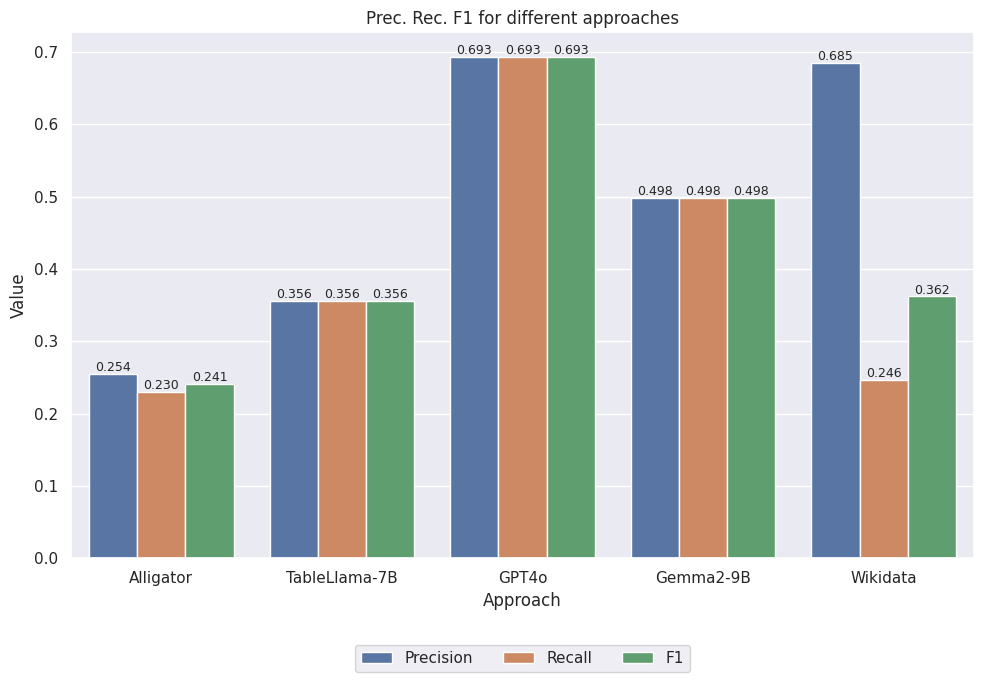

In [66]:
sns.set_context("paper")
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.barplot(
    scores_df,
    x="Approach",
    y="Value",
    hue="metric",
    ax=ax,
    legend=True,
)
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", fontsize=9)
ax.set_title(f"Prec. Rec. F1 for different approaches")
plt.legend()
sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5, -0.15), ncols=3)
plt.tight_layout()
plt.show()

### NIL accuracy per approach

In [67]:
# Compute the NIL accuracy per approach
nil_accuracy_by_approach = {
    "Alligator nil@0.2": gt_only_annotations_df_sub[gt_only_annotations_df_sub["target"] == "NIL"]["nil_match@0.2"].mean(),
    "TableLlama-7B": tablellama_df[tablellama_df["target"] == "NIL"]["tablellama_match"].mean(),
    "Gemma2-9B": gemma2_df[gemma2_df["target"] == "NIL"]["llm_match"].mean(),
    "GPT4o": gpt_df[gpt_df["target"] == "NIL"]["gpt_match"].mean(),
}

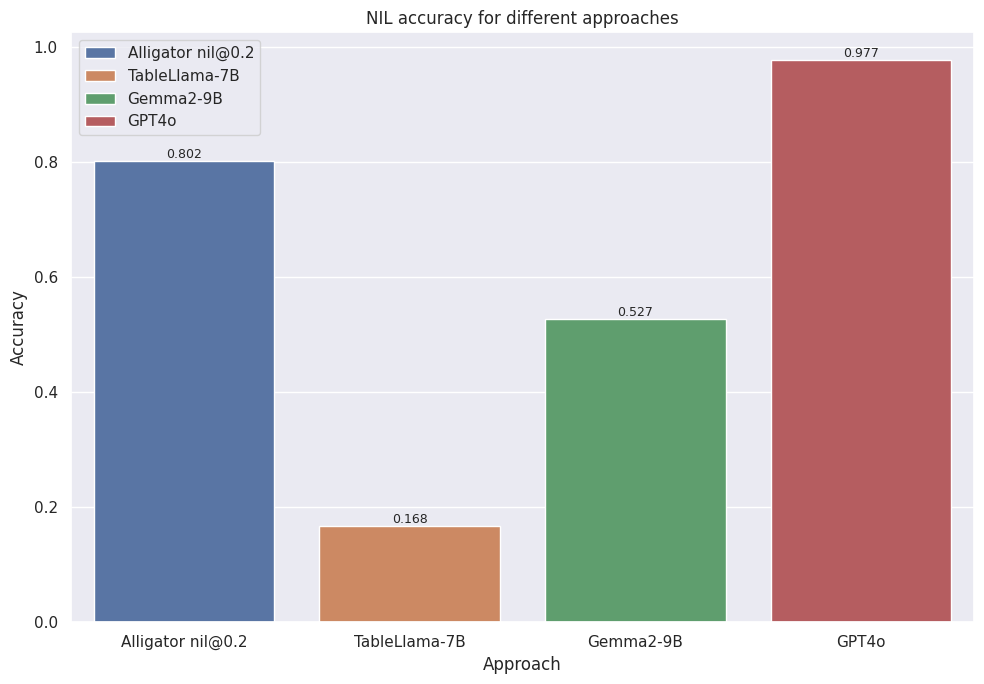

In [69]:
# Plot the results
sns.set_context("paper")
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.barplot(
    x=list(nil_accuracy_by_approach.keys()),
    y=list(nil_accuracy_by_approach.values()),
    ax=ax,
    legend=True,
    hue=list(nil_accuracy_by_approach.keys()),
)
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", fontsize=9)
ax.set_title(f"NIL accuracy for different approaches")
ax.set_xlabel("Approach")
ax.set_ylabel("Accuracy")
plt.tight_layout()
plt.show()

In [90]:
len(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["target"] == "NIL")
        & (gt_only_annotations_df_sub["nil_match@0.2"] == 1)
        & (gt_only_annotations_df_sub["candidates"] >= 10)
    ]
), len(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["target"] == "NIL") & (gt_only_annotations_df_sub["nil_match@0.2"] == 1)
    ]
), len(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["target"] == "NIL")
        & (gt_only_annotations_df_sub["nil_match@0.2"] == 1)
        & (gt_only_annotations_df_sub["candidates"] >= 10)
    ]
) / len(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["target"] == "NIL") & (gt_only_annotations_df_sub["nil_match@0.2"] == 1)
    ]
)

(76, 105, 0.7238095238095238)

In [91]:
len(
    tablellama_df[
        (tablellama_df["target"] == "NIL")
        & (tablellama_df["tablellama_match"] == 1)
        & (tablellama_df["candidates"] >= 10)
    ]
), len(tablellama_df[(tablellama_df["target"] == "NIL") & (tablellama_df["tablellama_match"] == 1)]), len(
    tablellama_df[
        (tablellama_df["target"] == "NIL")
        & (tablellama_df["tablellama_match"] == 1)
        & (tablellama_df["candidates"] >= 10)
    ]
) / len(
    tablellama_df[(tablellama_df["target"] == "NIL") & (tablellama_df["tablellama_match"] == 1)]
)

(2, 22, 0.09090909090909091)

In [92]:
len(gemma2_df[(gemma2_df["target"] == "NIL") & (gemma2_df["llm_match"] == 1) & (gemma2_df["candidates"] >= 10)]), len(
    gemma2_df[(gemma2_df["target"] == "NIL") & (gemma2_df["llm_match"] == 1)]
), len(
    gemma2_df[(gemma2_df["target"] == "NIL") & (gemma2_df["llm_match"] == 1) & (gemma2_df["candidates"] >= 10)]
) / len(
    gemma2_df[(gemma2_df["target"] == "NIL") & (gemma2_df["llm_match"] == 1)]
)

(45, 69, 0.6521739130434783)

In [93]:
len(gpt_df[(gpt_df["target"] == "NIL") & (gpt_df["gpt_match"] == 1) & (gpt_df["candidates"] >= 10)]), len(
    gpt_df[(gpt_df["target"] == "NIL") & (gpt_df["gpt_match"] == 1)]
), len(gpt_df[(gpt_df["target"] == "NIL") & (gpt_df["gpt_match"] == 1) & (gpt_df["candidates"] >= 10)]) / len(
    gpt_df[(gpt_df["target"] == "NIL") & (gpt_df["gpt_match"] == 1)]
)

(100, 128, 0.78125)

### Other statistics

In [ ]:
len(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["nil_match@0.2"] == 0)
        & (gt_only_annotations_df_sub["target_in_candidates"] == False)
        & (gt_only_annotations_df_sub["target"] != "NIL")
    ]
), len(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["nil_match@0.2"] == 0) & (gt_only_annotations_df_sub["target"] != "NIL")
    ]
), len(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["nil_match@0.2"] == 0)
        & (gt_only_annotations_df_sub["target_in_candidates"] == False)
        & (gt_only_annotations_df_sub["target"] != "NIL")
    ]
) / len(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["nil_match@0.2"] == 0) & (gt_only_annotations_df_sub["target"] != "NIL")
    ]
)

In [ ]:
len(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["alligator_match"] == 0)
        & (gt_only_annotations_df_sub["target_in_candidates"] == False)
        & (gt_only_annotations_df_sub["target"] != "NIL")
    ]
), len(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["alligator_match"] == 0) & (gt_only_annotations_df_sub["target"] != "NIL")
    ]
), len(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["alligator_match"] == 0)
        & (gt_only_annotations_df_sub["target_in_candidates"] == False)
        & (gt_only_annotations_df_sub["target"] != "NIL")
    ]
) / len(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["alligator_match"] == 0) & (gt_only_annotations_df_sub["target"] != "NIL")
    ]
)

In [74]:
lamapi_errors_by_approach = {
    "alligator": (
        len(
            gt_only_annotations_df_sub[
                (gt_only_annotations_df_sub["nil_match@0.2"] == 0)
                & (gt_only_annotations_df_sub["target_in_candidates"] == False)
                & (gt_only_annotations_df_sub["target"] != "NIL")
            ]
        ),
        len(
            gt_only_annotations_df_sub[
                (gt_only_annotations_df_sub["nil_match@0.2"] == 0) & (gt_only_annotations_df_sub["target"] != "NIL")
            ]
        ),
    ),
    "tablellama": (
        len(
            tablellama_df[
                (tablellama_df["tablellama_match"] == 0)
                & (tablellama_df["target_in_candidates"] == False)
                & (tablellama_df["target"] != "NIL")
            ]
        ),
        len(tablellama_df[(tablellama_df["tablellama_match"] == 0) & (tablellama_df["target"] != "NIL")]),
    ),
    "gpt4o": (
        len(
            gpt_df[(gpt_df["gpt_match"] == 0) & (gpt_df["target_in_candidates"] == False) & (gpt_df["target"] != "NIL")]
        ),
        len(gpt_df[(gpt_df["gpt_match"] == 0) & (gpt_df["target"] != "NIL")]),
    ),
}

In [ ]:
lamapi_errors_by_approach

In [ ]:
tablellama_df[
    (tablellama_df["tablellama_match"] == 0)
    & (tablellama_df["target_in_candidates"] == False)
    & (tablellama_df["target"] != "NIL")
]["mention"].tolist()

In [77]:
tllama_wrong_mentions = set(
    tablellama_df[(tablellama_df["tablellama_match"] == 0) & (tablellama_df["target_in_candidates"] == 1)][
        "mention"
    ].tolist()
)

In [78]:
gpt_wrong_mentions = set(gpt_df[(gpt_df["gpt_match"] == 0) & (gpt_df["target_in_candidates"] == 1)]["mention"].tolist())

In [79]:
alligator_wrong_mentions = set(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["nil_match@0.2"] == 0) & (gt_only_annotations_df_sub["target_in_candidates"] == 1)
    ]["mention"].tolist()
)

In [ ]:
iou_alligator_tablellama = len(tllama_wrong_mentions.intersection(alligator_wrong_mentions)) / len(
    tllama_wrong_mentions.union(alligator_wrong_mentions)
)
iou_alligator_tablellama

In [ ]:
iou_alligator_gpt = len(gpt_wrong_mentions.intersection(alligator_wrong_mentions)) / len(
    gpt_wrong_mentions.union(alligator_wrong_mentions)
)
iou_alligator_gpt

In [ ]:
iou_gpt_tablellama = len(tllama_wrong_mentions.intersection(gpt_wrong_mentions)) / len(
    tllama_wrong_mentions.union(gpt_wrong_mentions)
)
iou_gpt_tablellama

In [ ]:
alligator_wrong_mentions.difference(tllama_wrong_mentions)

In [ ]:
tllama_wrong_mentions.difference(alligator_wrong_mentions)

In [ ]:
alligator_wrong_mentions.intersection(tllama_wrong_mentions)

### GPT token and price estimation

In [86]:
results_path = "/home/belerico/Desktop/unimib/business cases/gh/results_gpt4o_2024-02-15-preview/gh_end_to_end_prompts/subsampled_ctx_red_5_gh_end_to_end_prompts_gpt4o.json"

In [87]:
results = json.load(open(results_path))

In [88]:
prompt_template = (
    "Below is an instruction that describes a task, paired with an input that provides further context. "
    "Write a response that appropriately completes the request.\n\n"
    "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Question:\n{question}\n\n"
    "Repeat only the correct candidate, along with its description and types, if any, and nothing else. "
    "Answer with NIL if no correct candidate can be found in the candidate list.\n\n"
    "### Response:\n"
)

In [89]:
input_chars = 0
output_chars = 0
chars_to_token = 4
for example in results:
    input_chars += len(prompt_template.format(**example))
    output_chars += len(example["gpt_output"])
input_tokens = input_chars / chars_to_token
output_tokens = output_chars / chars_to_token

In [90]:
input_tokens_price = 5.00 / 1e6
output_tokens_price = 15.00 / 1e6

In [ ]:
input_tokens_price * input_tokens

In [ ]:
output_tokens_price * output_tokens

In [ ]:
avg_row_input_chars = input_chars / len(results)
avg_row_output_chars = output_chars / len(results)

avg_row_input_tokens = avg_row_input_chars / chars_to_token
avg_row_output_tokens = avg_row_output_chars / chars_to_token

input_tokens_price * avg_row_input_tokens, output_tokens_price * avg_row_output_tokens

In [ ]:
input_tokens_price * avg_row_input_tokens + output_tokens_price * avg_row_output_tokens